# Import the appropriate libraries

In [77]:
import os
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers, Sequential
import sys
from tensorflow.python.platform import build_info as info
from tensorflow.python.client import device_lib
import platform

# Versions of Tensorflow - Keras - CUDA - cuDNN - GPU

In [91]:
# Host OS info
print("Operating System:", platform.system())
print("OS Version:", platform.version())
print("OS Details:", platform.platform())

# Print TensorFlow version
print("\nTensorFlow version:", tf.__version__)

# Print Keras version
print("\nKeras version:", keras.__version__)

# Print Python version
print("\nPython version:", sys.version)

# Print CUDA and cuDNN versions (related to GPU support)
print("\nCUDA - cuDNN version:", info.build_info)

# Print GPU info
devices = device_lib.list_local_devices()

for device in devices:
    if device.device_type == 'GPU':
        print(f"GPU Model: {device.physical_device_desc}")

Operating System: Linux
OS Version: #1 SMP Fri Mar 29 23:14:13 UTC 2024
OS Details: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.39

TensorFlow version: 2.17.0

Keras version: 3.5.0

Python version: 3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:27:27) [GCC 11.2.0]

CUDA - cuDNN version: OrderedDict({'cpu_compiler': '/usr/lib/llvm-17/bin/clang', 'cuda_compute_capabilities': ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90'], 'cuda_version': '12.3', 'cudnn_version': '8', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': True})
GPU Model: device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


I0000 00:00:1727609886.961847  778839 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727609886.961938  778839 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727609886.961961  778839 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727609886.962193  778839 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 14:38:06.962214: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

# Import Training and Testing datasets

In [3]:
train_dir = '/home/cslab010/Ai_ML_Projects/AUEB_Ai_ResNet50_/ImageDATA/train_data_2'
test_dir = '/home/cslab010/Ai_ML_Projects/AUEB_Ai_ResNet50_/ImageDATA/test_data_2'

# Image Data pre-processing -- Data Augmentation and Normalization

In [5]:
# Since the dataset is folder-structured, set the parameteres to load data from directory and set their parameters

# Set the image resolution
img_size = (224, 224)

# Set the batch size number
batch_size = 32

# Train Dataset creation (split of 90% of the initial dataset)
train_generator = image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,  # 90% for training, 10% for validation
    subset = "training",
    seed = 42,  # Set seed to ensure consistent splitting
    image_size = img_size,
    batch_size = batch_size,

    # Label mode for classification purposes
    label_mode = 'categorical',
    shuffle = True
)


# Validation dataset creation (split of 10% of the initial dataset)
val_generator = image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset = "validation",
    seed = 42,  # Same seed as above
    image_size = img_size,
    batch_size = batch_size,

    # Label mode for classification purposes
    label_mode = 'categorical',
    shuffle = True
)

# Test dataset creation
test_generator = image_dataset_from_directory(
    test_dir,
    image_size = img_size,
    batch_size = batch_size,
    label_mode = 'categorical',
    shuffle = False # do not shuffle data!
)

Found 382 files belonging to 4 classes.
Using 344 files for training.
Found 382 files belonging to 4 classes.
Using 38 files for validation.
Found 48 files belonging to 4 classes.


In [6]:
# Data augmentation: Random flips, rotations, zooms, etc.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [8]:
# Normalize the images to [0, 1] range (as required for pre-trained models)
normalization = tf.keras.layers.Rescaling(1./255)


# Apply both data augmentation and normalization to the Train dataset
def preprocess_train(image, label):
    
    # Apply data augmentation (during training)
    image = data_augmentation(image)

    # Normalize the image to [0, 1] range
    image = normalization(image)

    return image, label

# Map the preprocessing function to the dataset
train_dataset = train_generator.map(preprocess_train)


# Normalize Validation data, as well
def preprocess_val_test(image, label):
    
    # Normalize the image to [0, 1] range
    image = normalization(image)

    return image, label

# Apply only normalization to the Validation dataset
val_dataset = val_generator.map(preprocess_val_test)


# Normalize Test data
test_dataset = test_generator.map(preprocess_val_test)


# Input image shape
images, labels = next(iter(train_dataset))
print("Image shape: ", images.shape, labels.shape)

Image shape:  (32, 224, 224, 3) (32, 4)


2024-09-29 13:23:48.624961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 555328424458635403
2024-09-29 13:23:48.625000: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node sequential_1/random_flip_1/ReadVariableOp_1/_22}}]]
	 [[sequential_1/random_flip_1/Add/_14]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-09-29 13:23:48.625098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15954889499891589353
2024-09-29 13:23:48.625117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12329220687699160327
2024-09-29 13:23:48.625120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5941795929192642307


# Training Image Examples

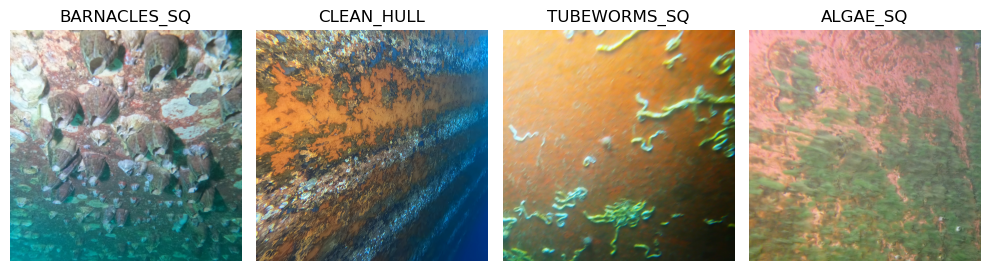

In [9]:
# Return α list with the class names within the folder-structure data directory
ClassNames_LIST = os.listdir(train_dir)

# Plot initialization
plt.figure(figsize=(10, 10))

# Loop through the folder-structure  directory and plot the first image of each class subfolder
for index, ClassName in enumerate(ClassNames_LIST):

    # Get the corresponding class sub-directory
    Class_subDIR = os.path.join(train_dir, ClassName)

    # Execute if the path is a directory
    if os.path.isdir(Class_subDIR):
        
        # Get the first image file from the corresponding class sub-directory
        ImageFile = os.listdir(Class_subDIR)[0]

        # Get the path of the first image
        ImagePath = os.path.join(Class_subDIR, ImageFile)
        
        # Image Ploting
        Image = mpimg.imread(ImagePath)
        plt.subplot(1, len(ClassNames_LIST), index + 1)
        plt.imshow(Image)
        plt.title(ClassName)
        plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

# Load ResNet50 pre-trained image classification model

In [11]:
# Load the ResNet50 Pre-trained model
ResNet_Model = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

# Freeze the pre-trained layers
ResNet_Model.trainable = False

#  Create new custom Model using the ResNet50 pre-trained model as base

In [12]:
def new_MODEL(pretrained_base_model, trainabilty):
    
    # Create sequential model
    model = Sequential()
    
    # Add the pretrained ResNet50 model layers to model
    model.add(pretrained_base_model)

    # Trainablity of the pre-trained layers
    ResNet_Model.trainable = trainabilty
    
    # Add fully connected layers for classification
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(4, activation = 'softmax'))

    return model

# Compile and fit the Model for training

In [13]:
# Create a sequential model
model_0 = new_MODEL(ResNet_Model, False)

# Model compilation passing the appropriate paramaterers
model_0.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Set the the training datataset batch size and the number of epochs
bs = batch_size
n_epochs = 100

# Train the model while tracking the training progress
history_0 = model_0.fit(train_dataset, epochs = n_epochs, validation_data = val_dataset, verbose = 1, batch_size = bs)

Epoch 1/100


I0000 00:00:1727605520.848231  778954 service.cc:146] XLA service 0x7f1c8c001fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727605520.848263  778954 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-09-29 13:25:20.931348: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-29 13:25:21.405659: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2266 - loss: 7.4944

I0000 00:00:1727605524.804932  778954 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 851ms/step - accuracy: 0.2614 - loss: 9.6518 - val_accuracy: 0.3158 - val_loss: 3.3002
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.3674 - loss: 2.6431 - val_accuracy: 0.4474 - val_loss: 1.6175
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.4944 - loss: 1.4917 - val_accuracy: 0.6579 - val_loss: 0.8553
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.5408 - loss: 1.0636 - val_accuracy: 0.6842 - val_loss: 0.6419
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.5871 - loss: 0.8526 - val_accuracy: 0.5263 - val_loss: 0.8219
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.6022 - loss: 0.8367 - val_accuracy: 0.6579 - val_loss: 0.7250
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.5658 - loss: 0.9089 - val_accuracy: 0.7105 - val_loss: 0.6788
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6326 - loss: 0.7804 - val_accuracy: 0.552

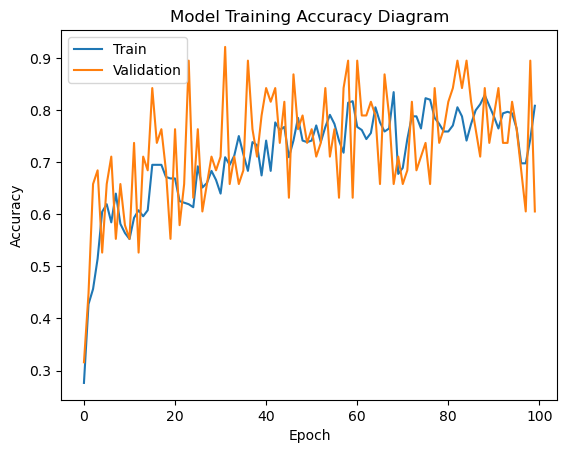

In [14]:
# Define function for ploting Model Training Accuracy progress
def plot_hist(history_0):
    plt.plot(history_0.history["accuracy"])
    plt.plot(history_0.history["val_accuracy"])
    plt.title("Model Training Accuracy Diagram")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc = "upper left")
    plt.show()

# Plot Model Training Accuracy Diagram
plot_hist(history_0)

# Evaluate model on unseen Testing data

In [15]:
# Define model evaluation function

def evaluate_MODEL(model, test_dataset):
         
    test_loss, test_acc = model.evaluate(test_dataset)
    
    print(f"Test accuracy: {round(test_acc, 3)}")
    print(f"Test loss: {round(test_loss, 3)}")


In [16]:
# Call model evaluation function
evaluate_MODEL(model_0, test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6319 - loss: 1.1817  
Test accuracy: 0.667
Test loss: 1.06


# Confusion Matrix for per-class model prediction

In [17]:
# Define Confusio Matrix function

def get_ConfusionMatrix(model, test_dataset, test_generator):

    # Unbatch the (previously batched) image dataset and get the True One-Hot encoded image labels
    Y_true = np.concatenate([y for x, y in test_dataset], axis = 0)
    
    # Convert One-Hot image labels to the corresponing class index
    Y_true_labels = np.argmax(Y_true, axis = 1)  
    
    # Pass through the Test Dataset to get the predicted class probabilities
    Y_pred_prob = model.predict(test_dataset)
    
    # Convert the predicted probabilities to the corresponding class label
    Y_pred_labels = np.argmax(Y_pred_prob, axis = 1)  
    
    # Get the Confusion Matrix 
    Confusion_Matrix = confusion_matrix(Y_true_labels, Y_pred_labels)
    
    # Get the names of each class
    Class_Names = list(test_generator.class_names)
    
    # Confusion Matrix plotting
    plt.figure(figsize = (7, 5))
    sns.heatmap(Confusion_Matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = Class_Names, yticklabels = Class_Names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Return information about the Precision - Recalls values of each class
    print(classification_report(Y_true_labels, Y_pred_labels, target_names = Class_Names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


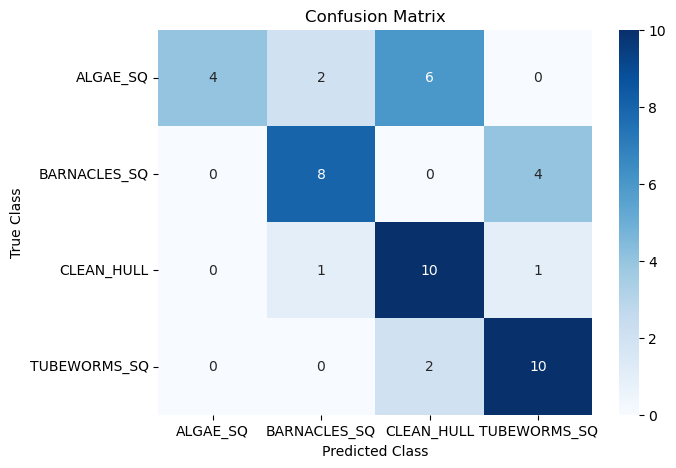

              precision    recall  f1-score   support

    ALGAE_SQ       1.00      0.33      0.50        12
BARNACLES_SQ       0.73      0.67      0.70        12
  CLEAN_HULL       0.56      0.83      0.67        12
TUBEWORMS_SQ       0.67      0.83      0.74        12

    accuracy                           0.67        48
   macro avg       0.74      0.67      0.65        48
weighted avg       0.74      0.67      0.65        48



In [18]:
# Call Confusion Matrix function
get_ConfusionMatrix(model_0, test_dataset, test_generator)

# Train again with 100% of the dataset - no validation set

In [23]:
# Train 100% Dataset creation
train_generator_100percent = image_dataset_from_directory(
    train_dir,
    image_size = img_size,
    batch_size = batch_size,

    # Label mode for classification purposes
    label_mode = 'categorical',
    shuffle = True
)

# Map the preprocessing function to the dataset
train_dataset_100percent = train_generator_100percent.map(preprocess_train)


# Define new model - model_100
model_100 = new_MODEL(ResNet_Model, False)

# Model compilation passing the appropriate paramaterers
model_100.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Set the the training datataset batch size and the number of epochs
bs = batch_size
n_epochs = 100

# Train the model while tracking the training progress
history = model_100.fit(train_dataset_100percent, epochs = n_epochs, verbose = 1, batch_size = bs)

Found 382 files belonging to 4 classes.
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.2359 - loss: 12.6549
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.3525 - loss: 5.2701
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3795 - loss: 1.6451 
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5238 - loss: 1.2088
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5371 - loss: 0.9199
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.6336 - loss: 0.8018
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6290 - loss: 0.8666
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6319 - loss: 0.7946
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5254 - loss: 1.0481
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6319 - loss: 0.8032
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.6481 - loss: 0.8347


# Evaluate model on Test Dataet

In [24]:
# Call model evaluation function
evaluate_MODEL(model_100, test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 700ms/step - accuracy: 0.6910 - loss: 1.0120
Test accuracy: 0.708
Test loss: 0.93


# Prediction  - Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


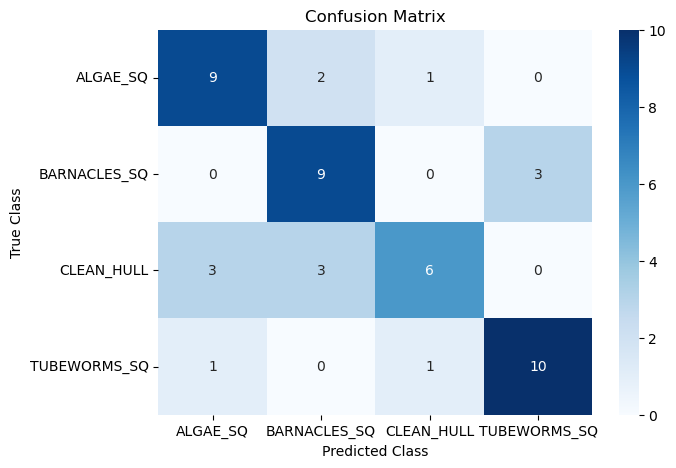

              precision    recall  f1-score   support

    ALGAE_SQ       0.69      0.75      0.72        12
BARNACLES_SQ       0.64      0.75      0.69        12
  CLEAN_HULL       0.75      0.50      0.60        12
TUBEWORMS_SQ       0.77      0.83      0.80        12

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.70        48
weighted avg       0.71      0.71      0.70        48



In [27]:
# Call Confusion Matrix function
get_ConfusionMatrix(model_100, test_dataset, test_generator)

# Save both Model_100 and Model_100 weights

In [36]:
# Save entire Model_100
model_100.save('./model_100_TOTAL.keras')

# Save Model_100 weights
model_100.save_weights('./model_100_weights.weights.h5')

# Try Fine Tuning -- UnFreeze base model layers and fit again the model

In [59]:
# UnFreeze the pre-trained layers
ResNet_Model.trainable = True

# Load the entire model_100
loaded_model_100 = tf.keras.models.load_model('./model_100_TOTAL.keras')

# Compile again the Model_100 with the unfreezed base model layers and much lower Learning Rate
loaded_model_100.compile(optimizer = keras.optimizers.Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Set the the training datataset batch size and the number of epochs
bs = batch_size
n_epochs = 30

# Train the model while tracking the training progress
history = loaded_model_100.fit(train_dataset, validation_data = val_dataset, epochs = n_epochs, verbose = 1, batch_size = bs)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step - accuracy: 0.8406 - loss: 0.4648 - val_accuracy: 0.8684 - val_loss: 0.3427
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8359 - loss: 0.4109 - val_accuracy: 0.8947 - val_loss: 0.3589
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8439 - loss: 0.4208 - val_accuracy: 0.8684 - val_loss: 0.3840
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8383 - loss: 0.4287 - val_accuracy: 0.8947 - val_loss: 0.3706
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8546 - loss: 0.3901 - val_accuracy: 0.8947 - val_loss: 0.3689
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8445 - loss: 0.4252 - val_accuracy: 0.8947 - val_loss: 0.3557
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8455 - loss: 0.3923 - val_accuracy: 0.8947 - val_loss: 0.3565
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8867 - loss: 0.3640 - val_accuracy: 0.8

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step - accuracy: 0.6806 - loss: 0.9834
Test accuracy: 0.708
Test loss: 0.897
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


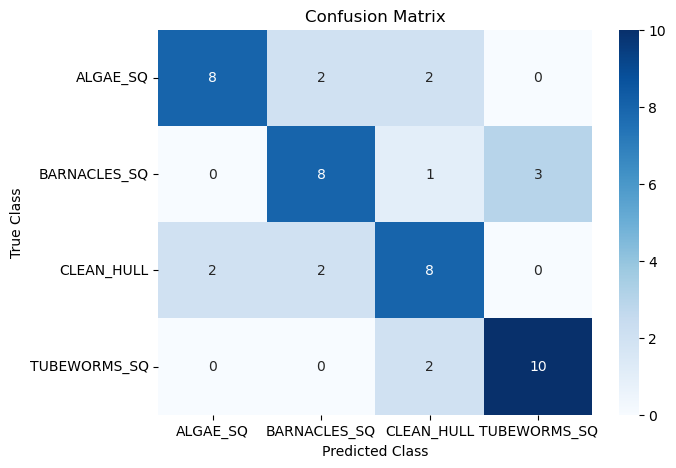

              precision    recall  f1-score   support

    ALGAE_SQ       0.80      0.67      0.73        12
BARNACLES_SQ       0.67      0.67      0.67        12
  CLEAN_HULL       0.62      0.67      0.64        12
TUBEWORMS_SQ       0.77      0.83      0.80        12

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.71        48
weighted avg       0.71      0.71      0.71        48



In [60]:
# Call model evaluation function
evaluate_MODEL(loaded_model_100, test_dataset)

# Call Confusion Matrix function
get_ConfusionMatrix(loaded_model_100, test_dataset, test_generator)

# Save Fine Tuned model_100

In [69]:
# Save entire Model_100
loaded_model_100.save('./FINE_TUNED_model_100_TOTAL.keras')

# Save Model_100 weights
loaded_model_100.save_weights('./FINE_TUNED_model_100_weights.weights.h5')

# EfficientNetB0 model fitting

In [84]:
from tensorflow.keras.applications import EfficientNetB0

In [86]:
# Load the ResNet50 Pre-trained model
EfficientNetB0_Model = EfficientNetB0(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

In [88]:
# Create a sequential model
ENetB0_Model = new_MODEL(EfficientNetB0_Model, False)

# Model compilation passing the appropriate paramaterers
ENetB0_Model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Set the the training datataset batch size and the number of epochs
bs = batch_size
n_epochs = 20

# Train the model while tracking the training progress
history_0 = ENetB0_Model.fit(train_dataset, epochs = n_epochs, validation_data = val_dataset, verbose = 1, batch_size = bs)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7470 - loss: 0.6276 - val_accuracy: 0.1842 - val_loss: 270.7858
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9453 - loss: 1.4689 - val_accuracy: 0.1842 - val_loss: 50.5788
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.9531 - loss: 1.9564 - val_accuracy: 0.2105 - val_loss: 14.8218
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9372 - loss: 0.6120 - val_accuracy: 0.5263 - val_loss: 3.1016
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9648 - loss: 0.2426 - val_accuracy: 0.2105 - val_loss: 145.5442
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9747 - loss: 0.2484 - val_accuracy: 0.2632 - val_loss: 60.9639
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9308 - loss: 0.2525 - val_accuracy: 0.1842 - val_loss: 140.1469
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9595 - loss: 0.2168 - val_accur

# EffientNet70 model evaluation

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2986 - loss: 5.7905  
Test accuracy: 0.292
Test loss: 5.612
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


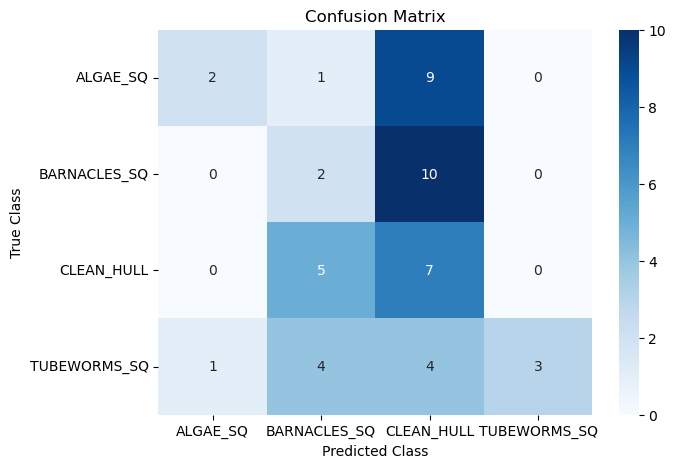

              precision    recall  f1-score   support

    ALGAE_SQ       0.67      0.17      0.27        12
BARNACLES_SQ       0.17      0.17      0.17        12
  CLEAN_HULL       0.23      0.58      0.33        12
TUBEWORMS_SQ       1.00      0.25      0.40        12

    accuracy                           0.29        48
   macro avg       0.52      0.29      0.29        48
weighted avg       0.52      0.29      0.29        48



In [89]:
# Call model evaluation function
evaluate_MODEL(ENetB0_Model, test_dataset)

# Call Confusion Matrix function
get_ConfusionMatrix(ENetB0_Model, test_dataset, test_generator)